In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")


### Loading the Dataset

In this step, we load the dataset from a CSV file into a pandas DataFrame. This allows us to easily explore and manipulate the data for further analysis. We then display the first few rows to get an overview of the data structure and contents.

In [2]:
df = pd.read_csv("data/data.csv") 
df.head() # Display the first 5 rows 

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790000,19.79,NaN,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.69333333333329,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,35.921144,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590000,19.79,45.000000,NaN,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.33333333333329,19.2,44.530000,19.79,45.000000,18.890000,...,4.476511,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.900000,10.084097,10.084097


In [3]:
df.info() # Display the data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     16857 non-null  object 
 1   equipment_energy_consumption  16013 non-null  object 
 2   lighting_energy               16048 non-null  object 
 3   zone1_temperature             15990 non-null  object 
 4   zone1_humidity                16056 non-null  object 
 5   zone2_temperature             16004 non-null  object 
 6   zone2_humidity                15990 non-null  float64
 7   zone3_temperature             16055 non-null  float64
 8   zone3_humidity                15979 non-null  float64
 9   zone4_temperature             16041 non-null  float64
 10  zone4_humidity                16076 non-null  float64
 11  zone5_temperature             16019 non-null  float64
 12  zone5_humidity                16056 non-null  float64
 13  z

### Data Type Conversion

In [10]:
# Convert object columns to numeric
columns_to_convert = [
    'equipment_energy_consumption', 
    'lighting_energy', 
    'zone1_temperature', 
    'zone1_humidity', 
    'zone2_temperature'
]

# Using pandas to convert columns to numeric, coercing errors to NaN
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')



# Display the updated DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     16857 non-null  datetime64[ns]
 1   equipment_energy_consumption  15945 non-null  float64       
 2   lighting_energy               15993 non-null  float64       
 3   zone1_temperature             15908 non-null  float64       
 4   zone1_humidity                15969 non-null  float64       
 5   zone2_temperature             15934 non-null  float64       
 6   zone2_humidity                15990 non-null  float64       
 7   zone3_temperature             16055 non-null  float64       
 8   zone3_humidity                15979 non-null  float64       
 9   zone4_temperature             16041 non-null  float64       
 10  zone4_humidity                16076 non-null  float64       
 11  zone5_temperature           

In [83]:
df.describe() # Display summary statistics for numerical columns

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
count,16857,15945.000000,15993.000000,15908.000000,15969.000000,15934.000000,15990.000000,16055.000000,15979.000000,16041.000000,...,16084.000000,15969.000000,16051.000000,16015.000000,16058.000000,16029.000000,16042.000000,16031.000000,16031.000000,16033.000000
mean,2016-03-10 02:16:38.647446272,95.810413,3.938101,21.249414,39.046066,19.793113,39.494553,21.665733,38.201314,20.239922,...,18.851085,40.318199,6.218582,755.757602,78.977595,4.195988,38.457150,2.783507,24.854981,25.093780
min,2016-01-11 17:00:00,-1139.985693,-86.002966,8.726818,-46.660000,2.988199,-77.265503,6.543921,-71.406273,4.613485,...,4.476511,-81.582494,-37.524768,678.159940,-221.668765,-20.929527,-82.329792,-32.098095,-120.170177,-120.409590
25%,2016-02-09 21:20:00,50.000000,0.000000,20.500000,37.026667,18.600000,37.757500,20.533333,36.592500,19.266667,...,17.890000,38.230000,3.000000,750.800000,71.000000,2.000000,29.000000,0.450000,12.179924,12.193789
50%,2016-03-10 00:10:00,60.000000,0.000000,21.323333,39.226667,19.600000,40.293333,21.767500,38.400000,20.290000,...,18.890000,40.363333,6.000000,756.200000,84.166667,4.000000,40.000000,2.750000,24.866978,24.834261
75%,2016-04-08 03:40:00,100.000000,0.000000,22.100000,42.500000,20.790000,43.000000,22.760000,41.433333,21.356667,...,20.200000,43.790000,9.250000,762.100000,91.988095,6.000000,40.000000,5.308333,37.950236,37.971764
max,2016-12-01 15:50:00,1139.985693,86.002966,33.746609,76.292756,36.552882,77.265503,36.823982,71.406273,35.921144,...,33.238012,81.582494,49.853906,833.392675,221.668765,29.318719,159.606156,37.673716,170.156325,170.329617
std,NaN,182.753554,14.580575,2.165618,9.952521,2.943771,10.129513,2.594309,10.144388,2.783050,...,2.528783,11.168678,7.554684,13.643585,28.565660,4.409729,21.318655,6.094732,26.214960,25.523631


In [8]:
columns = df.columns
columns

Index(['timestamp', 'equipment_energy_consumption', 'lighting_energy',
       'zone1_temperature', 'zone1_humidity', 'zone2_temperature',
       'zone2_humidity', 'zone3_temperature', 'zone3_humidity',
       'zone4_temperature', 'zone4_humidity', 'zone5_temperature',
       'zone5_humidity', 'zone6_temperature', 'zone6_humidity',
       'zone7_temperature', 'zone7_humidity', 'zone8_temperature',
       'zone8_humidity', 'zone9_temperature', 'zone9_humidity',
       'outdoor_temperature', 'atmospheric_pressure', 'outdoor_humidity',
       'wind_speed', 'visibility_index', 'dew_point', 'random_variable1',
       'random_variable2'],
      dtype='object')

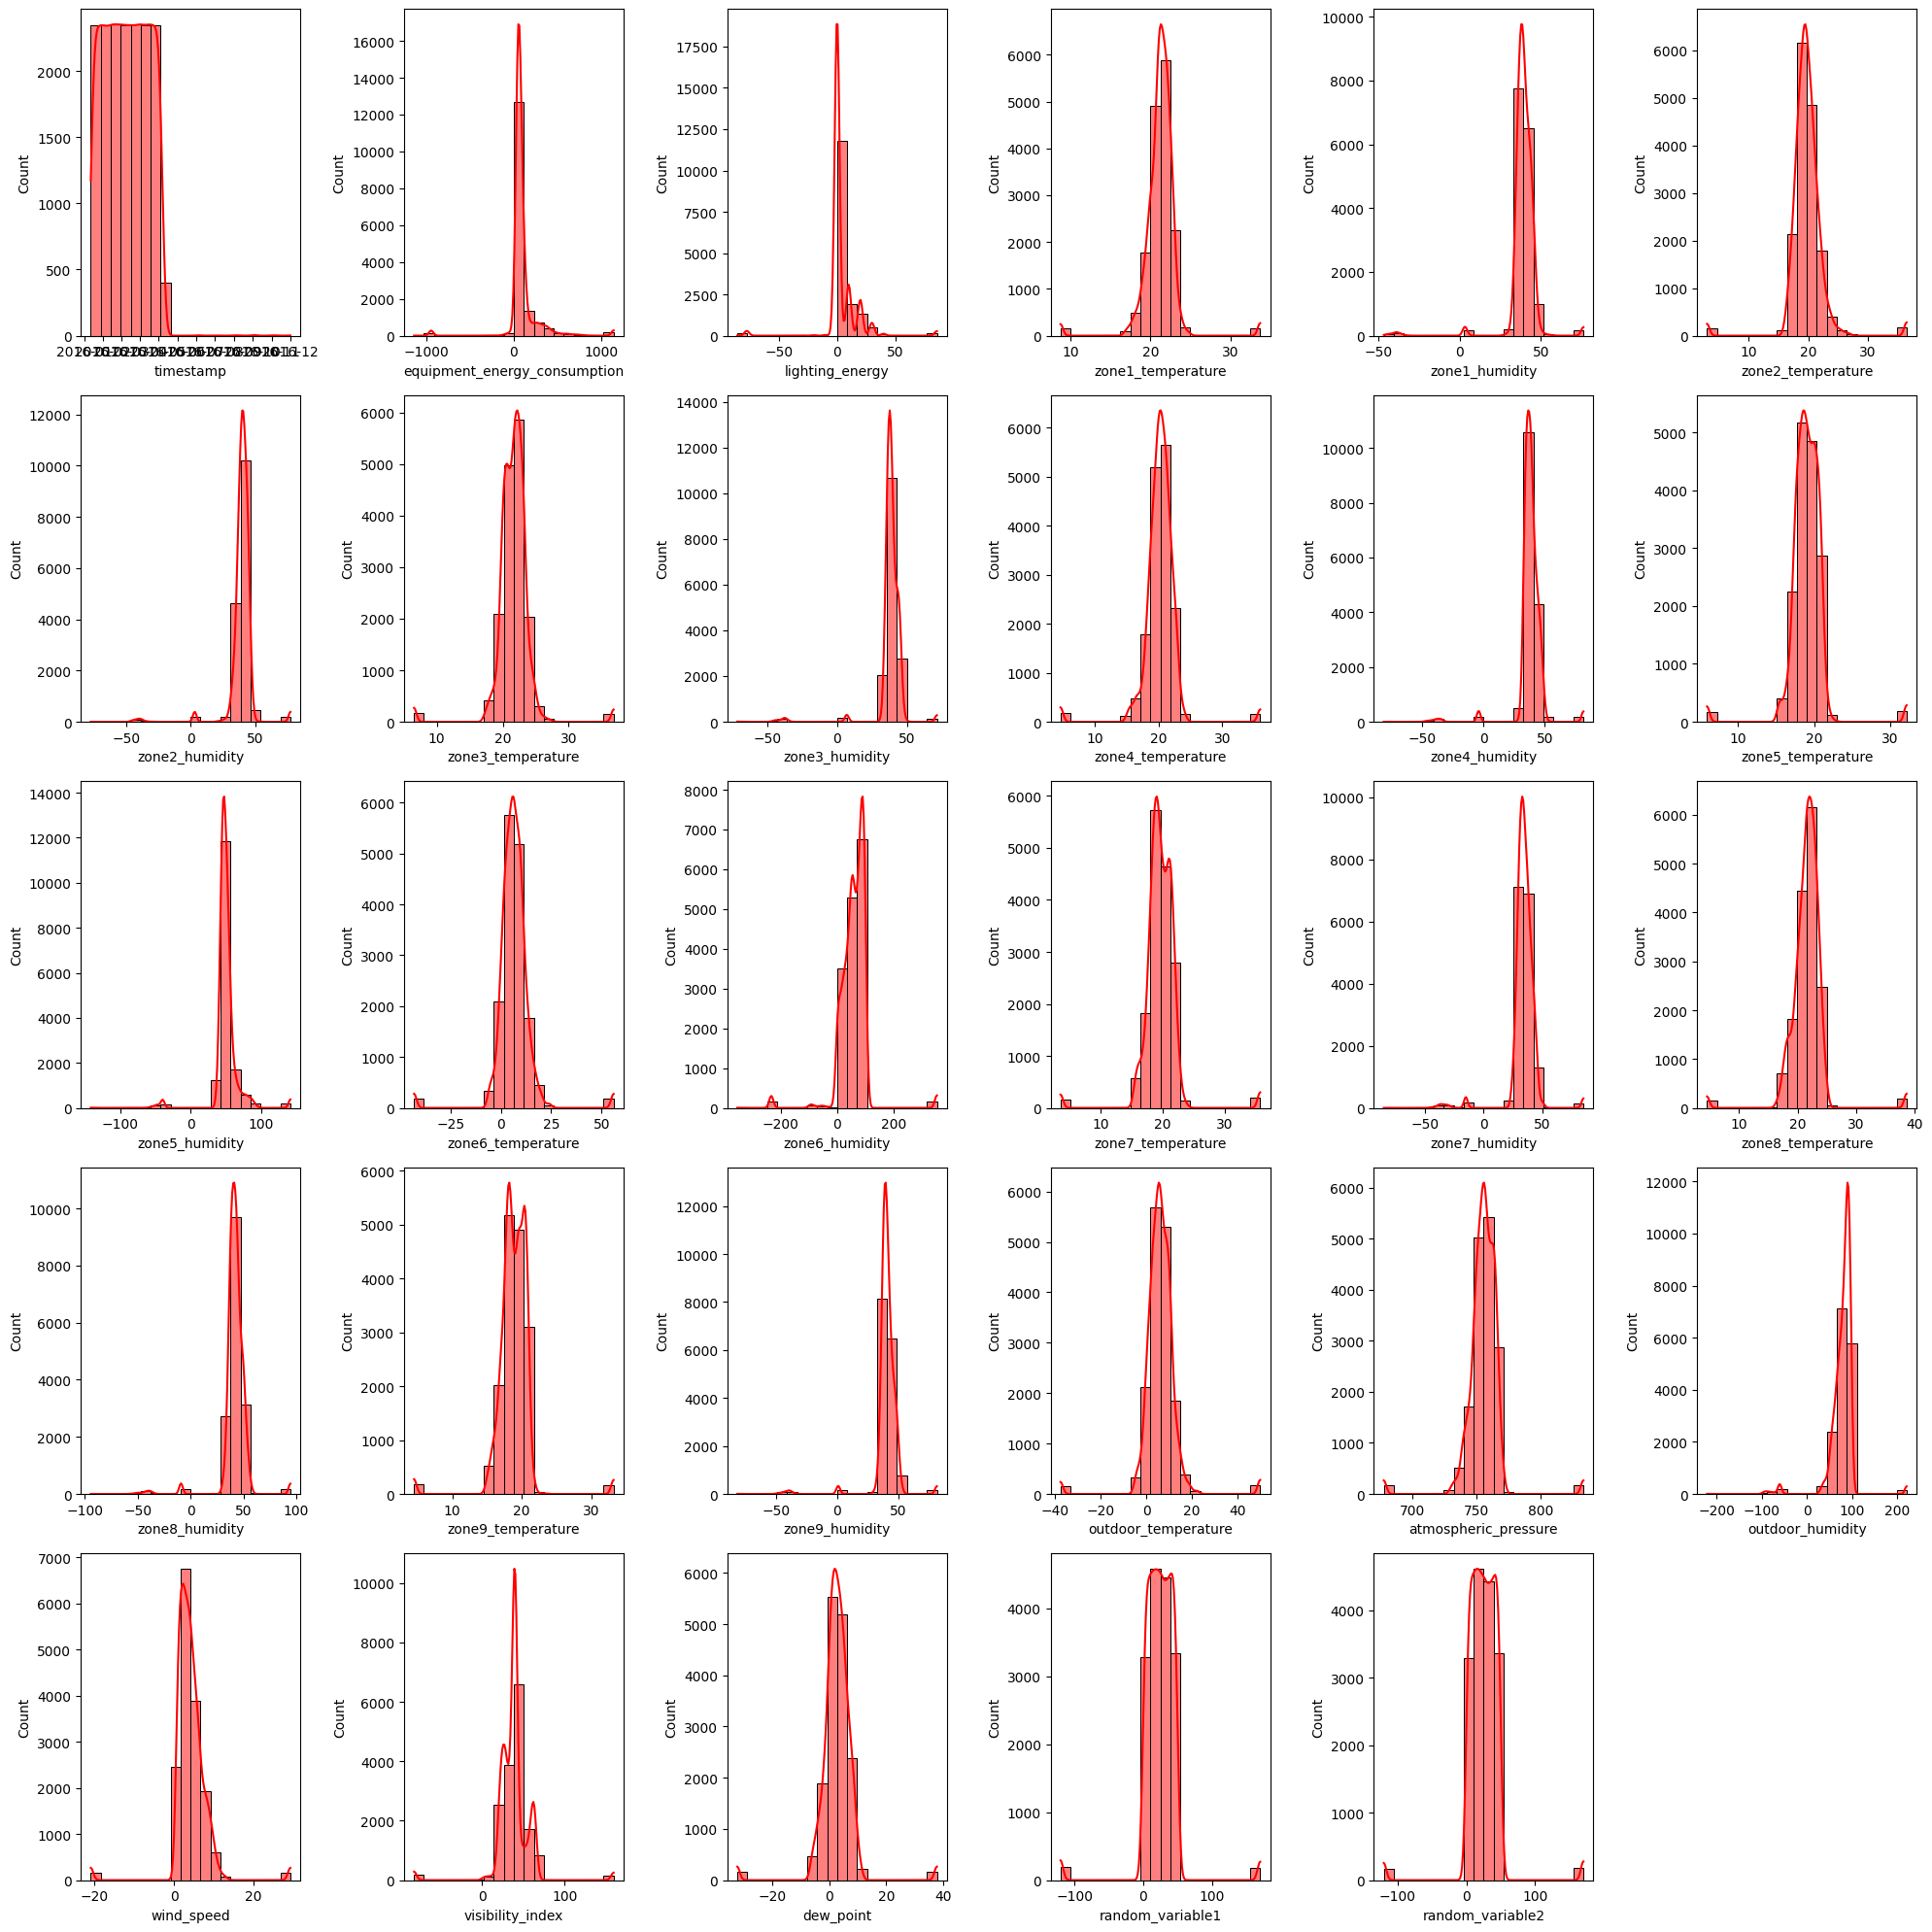

In [9]:
plt.figure(figsize=(20,20))
pt=1

for column in columns:
    ax= plt.subplot(5,6,pt)
    sns.histplot(df[column],bins=20,ax=ax, kde= True, color='red')
    ax.set_xlabel(column)
    pt+=1
plt.tight_layout()
plt.show()

In [86]:
# distribution of each numeric column
normality_results={}

for column in columns:
    clean_data= df[column].dropna()
    shapiro_test, p_value= shapiro(clean_data)
    normality_results[col]= p_value
    print(f"{column}: sw={shapiro_test}, p-value={p_value}")

timestamp: sw=0.953594554932914, p-value=1.0750745528271619e-57
equipment_energy_consumption: sw=0.5083394878250663, p-value=1.2403693942277996e-109
lighting_energy: sw=0.5019052676677773, p-value=4.689257172776367e-110
zone1_temperature: sw=0.6928136833445637, p-value=1.3119723092553788e-97
zone1_humidity: sw=0.4957808351415439, p-value=2.4606752480040433e-110
zone2_temperature: sw=0.6887634446598859, p-value=5.661651637937276e-98
zone2_humidity: sw=0.5066507983884005, p-value=8.457916219789056e-110
zone3_temperature: sw=0.7015994910687235, p-value=3.992198859611395e-97
zone3_humidity: sw=0.43862692105054946, p-value=3.421069590262553e-113
zone4_temperature: sw=0.690137261904511, p-value=4.929423103316542e-98
zone4_humidity: sw=0.5560020288812677, p-value=3.378651876591702e-107
zone5_temperature: sw=0.6920167401377377, p-value=7.551165227732498e-98
zone5_humidity: sw=0.5924513769867481, p-value=5.864126357957874e-105
zone6_temperature: sw=0.6909657982537438, p-value=6.450639679956665e

In [11]:
df.isnull().sum().sort_values(ascending=False)

zone1_temperature               949
zone2_temperature               923
equipment_energy_consumption    912
zone1_humidity                  888
zone9_humidity                  888
zone3_humidity                  878
zone2_humidity                  867
lighting_energy                 864
zone6_temperature               848
zone8_temperature               848
zone6_humidity                  847
atmospheric_pressure            842
zone5_temperature               838
wind_speed                      828
dew_point                       826
random_variable1                826
random_variable2                824
zone4_temperature               816
visibility_index                815
outdoor_temperature             806
zone7_humidity                  805
zone3_temperature               802
zone5_humidity                  801
outdoor_humidity                799
zone7_temperature               794
zone4_humidity                  781
zone8_humidity                  777
zone9_temperature           

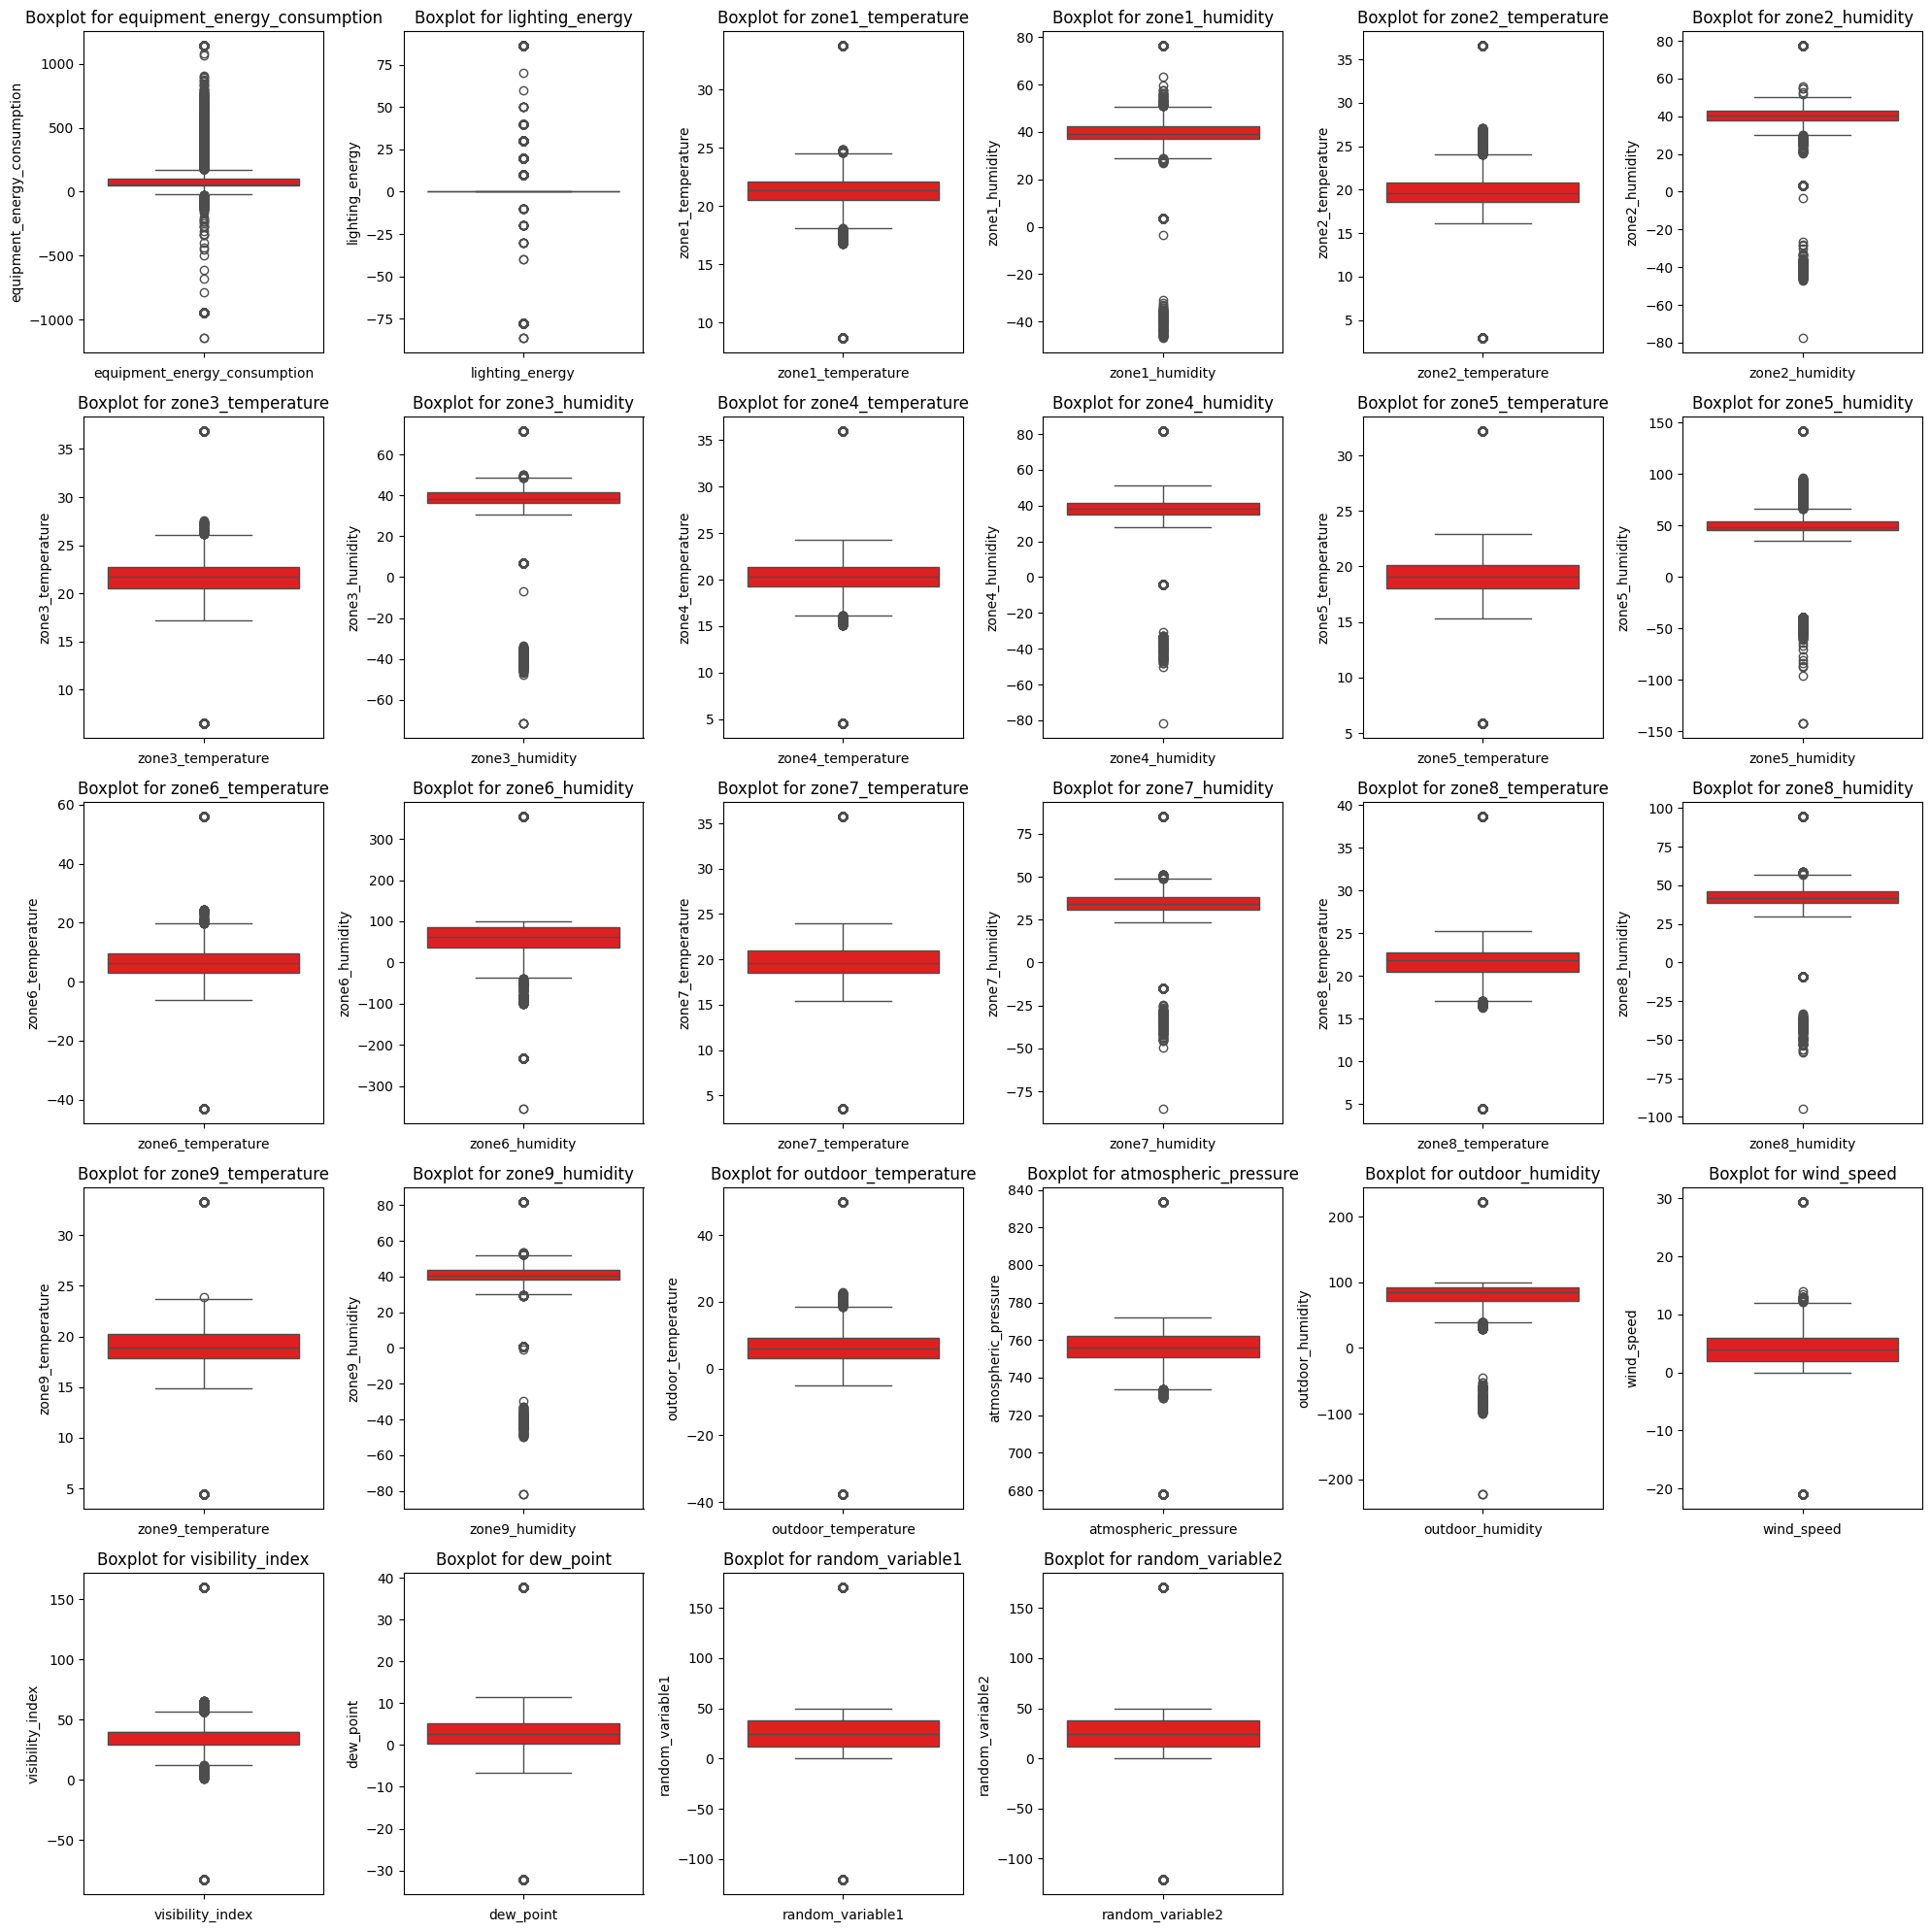

In [88]:
plt.figure(figsize=(20, 20))
pt = 1

for column in columns:
    if column != 'timestamp' :
        ax = plt.subplot(5, 6, pt)
        sns.boxplot(df[column], ax=ax, color='red')  # Boxplot for outliers
        ax.set_xlabel(column)
        ax.set_title(f'Boxplot for {column}')
        pt += 1

plt.tight_layout()
plt.show()

📊 1. Average Energy Consumption by Hour of Day

<Axes: title={'center': 'Avg Equipment Energy Consumption by Hour'}, xlabel='Hour', ylabel='Energy (kWh)'>

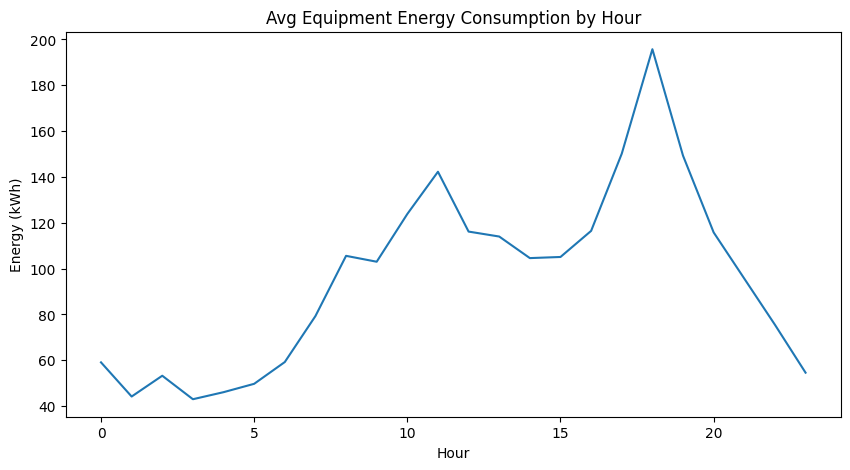

In [91]:
hourly_energy = df.groupby('hour_of_day')['equipment_energy_consumption'].mean()

hourly_energy.plot(kind='line', title='Avg Equipment Energy Consumption by Hour', xlabel='Hour', ylabel='Energy (kWh)', figsize=(10,5))

🌞 2. Energy Consumption by Shift

<Axes: title={'center': 'Avg Energy Consumption by Shift'}, xlabel='shift', ylabel='Energy (kWh)'>

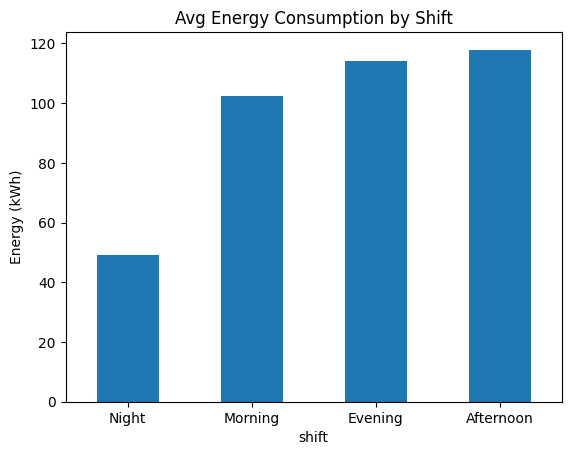

In [92]:
shift_energy = df.groupby('shift')['equipment_energy_consumption'].mean().sort_values()

shift_energy.plot(kind='bar', title='Avg Energy Consumption by Shift', ylabel='Energy (kWh)', rot=0)


📅 3. Energy Consumption by Day of Week

<Axes: title={'center': 'Avg Energy Consumption by Day of Week'}, xlabel='day_of_week', ylabel='Energy (kWh)'>

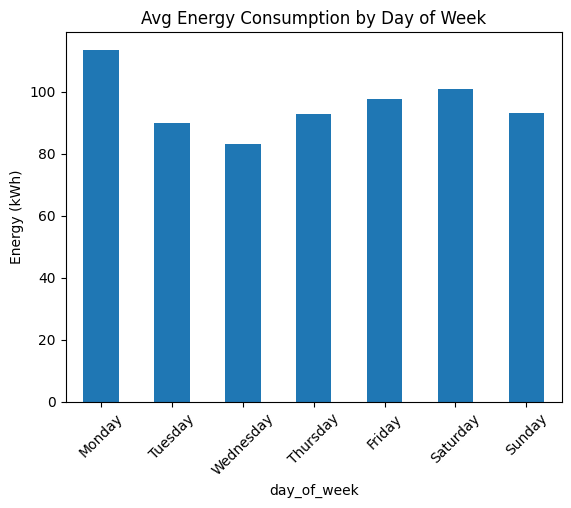

In [75]:
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_energy = df.groupby('day_of_week')['equipment_energy_consumption'].mean().reindex(dow_order)

day_energy.plot(kind='bar', title='Avg Energy Consumption by Day of Week', ylabel='Energy (kWh)', rot=45)


🌦️ 4. Energy Consumption by Season

<Axes: title={'center': 'Avg Energy Consumption by Season'}, xlabel='season', ylabel='Energy (kWh)'>

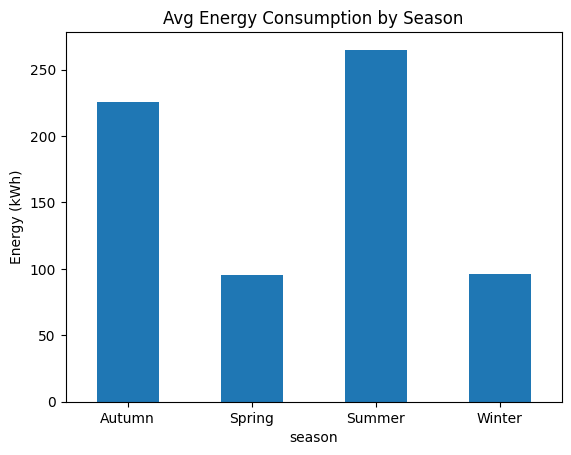

In [76]:
season_energy = df.groupby('season')['equipment_energy_consumption'].mean()

season_energy.plot(kind='bar', title='Avg Energy Consumption by Season', ylabel='Energy (kWh)', rot=0)


In [77]:
season_energy

season
Autumn    225.712242
Spring     95.269526
Summer    265.000000
Winter     96.364250
Name: equipment_energy_consumption, dtype: float64

In [12]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the dataset.
    """
    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Feature Engineering
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = df['day_of_week'] >= 5
    df['lag1_energy'] = df['equipment_energy_consumption'].shift(1)
    df['lag2_energy'] = df['equipment_energy_consumption'].shift(2)
    df['equipment_energy_consumption'] = pd.to_numeric(df['equipment_energy_consumption'], errors='coerce')
    df['equipment_energy_consumption_roll_mean_3'] = df['equipment_energy_consumption'].rolling(window=3).mean()

    # Data Cleaning
    df.replace('unknown', np.nan, inplace=True)
    df.drop(columns=['random_variable1', 'random_variable2'], inplace=True)
    df.dropna(inplace=True)

    # Visualize time series energy trend
    plt.figure(figsize=(14, 4))
    plt.plot(df['timestamp'], df['equipment_energy_consumption'], label='Energy Consumption')
    plt.title('Equipment Energy Consumption Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Energy Consumption')
    plt.tight_layout()
    plt.show()

    # Encode categorical variables
    for col in df.select_dtypes(include='object').columns:
        df[col] = pd.factorize(df[col])[0]

    # Correlation heatmap
    plt.figure(figsize=(20, 15))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    df.drop(columns=['timestamp'], inplace=True)

    return df

In [13]:
def split_and_scale_data(df):
    """
    Split the data into training and testing sets and scale the features.
    """
    X = df.drop(columns='equipment_energy_consumption')
    y = df['equipment_energy_consumption']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test, X.columns

In [14]:
def perform_grid_search(X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV for RandomForestRegressor.
    """
    rf = RandomForestRegressor(random_state=42)
    rf_params = {
        'n_estimators': [100, 150],
        'max_depth': [8, 10, 12]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    rf_grid = GridSearchCV(rf, rf_params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    return rf_grid.best_estimator_

In [15]:
def train_stacking_regressor(X_train, y_train, best_rf):
    """
    Train a stacking regressor using the best RandomForestRegressor, XGBRegressor, and GradientBoostingRegressor.
    """
    xgb = XGBRegressor(random_state=42, verbosity=0)
    gb = GradientBoostingRegressor(random_state=42)
    meta = Ridge()

    stack = StackingRegressor(
        estimators=[('rf', best_rf), ('xgb', xgb), ('gb', gb)],
        final_estimator=meta,
        passthrough=True
    )
    stack.fit(X_train, y_train)
    return stack

In [16]:

def evaluate_model(y_true, y_pred):
    """
    Evaluate the model performance using RMSE, MAE, and R² metrics.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.3f}")
    return rmse, mae, r2

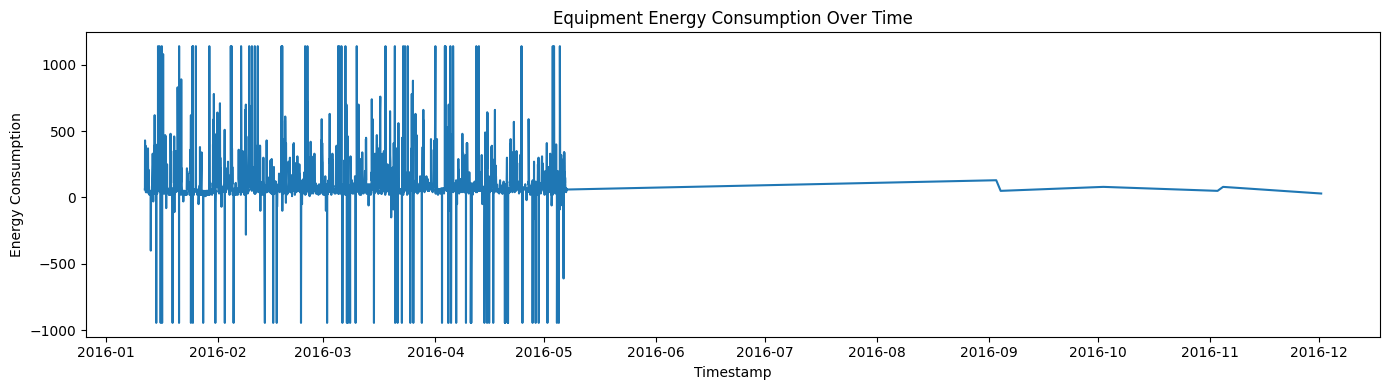

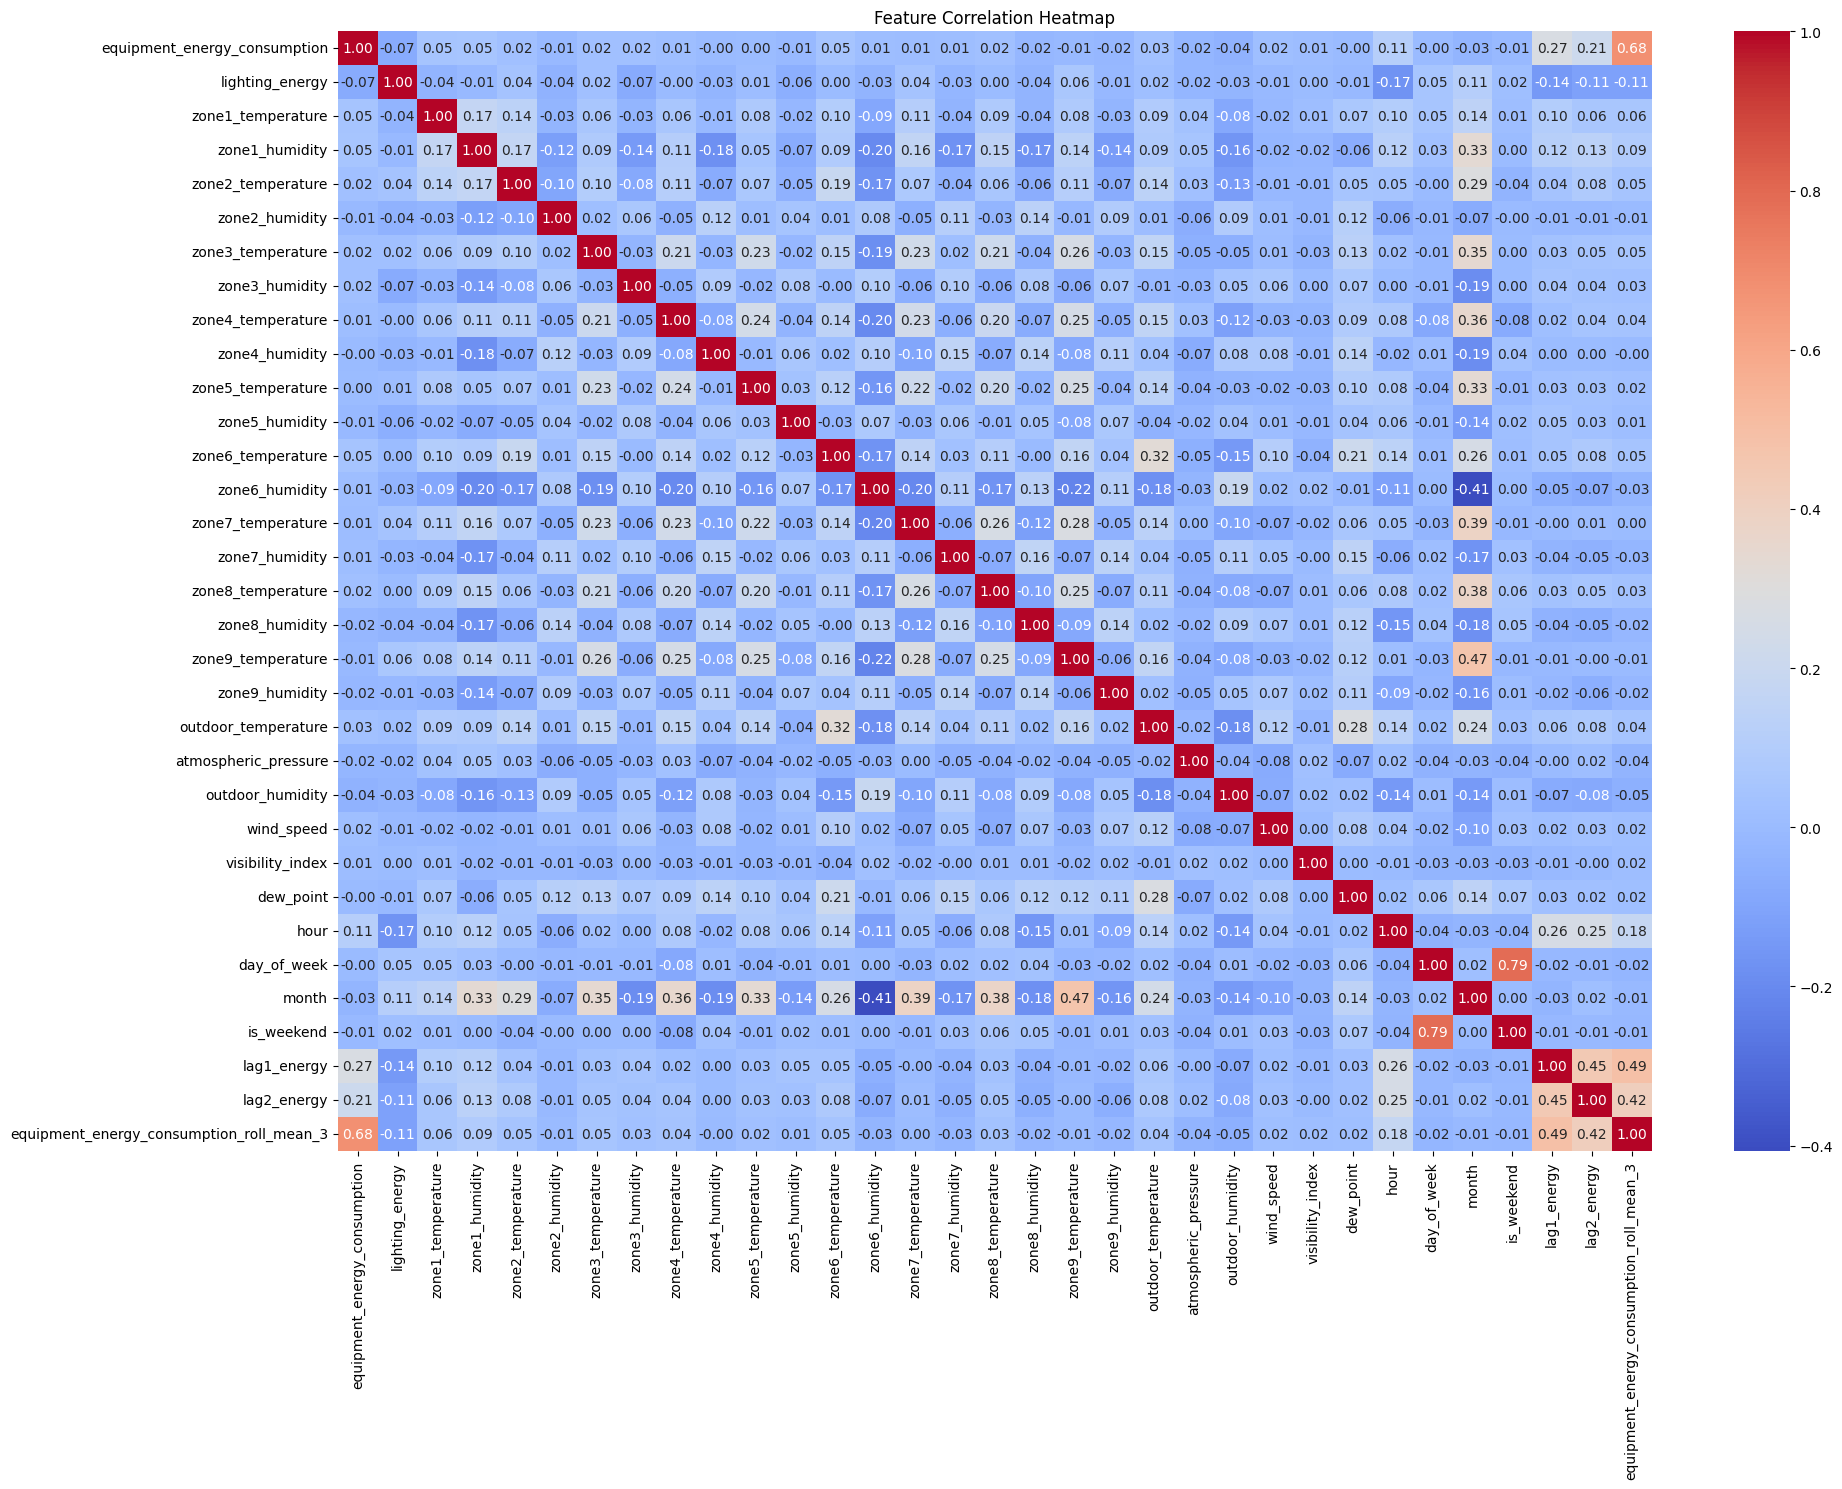


Model Performance on Test Set:
RMSE: 86.39
MAE: 28.49
R² Score: 0.768


In [20]:
def main():
    # Load and preprocess data
    df = load_and_preprocess_data("data/data.csv")

    # Split and scale data
    X_train, X_test, y_train, y_test, feature_names = split_and_scale_data(df)

    # Perform hyperparameter tuning
    best_rf = perform_grid_search(X_train, y_train)

    # Train stacking regressor
    stack = train_stacking_regressor(X_train, y_train, best_rf)

    # Predict and evaluate
    y_pred = stack.predict(X_test)
    print("\nModel Performance on Test Set:")
    evaluate_model(y_test, y_pred)

    



if __name__ == "__main__":
    main()